#Adversarial CNN Detection System for CAN BUS Cyber Attacks

##Please follow all steps and load files from the shared google drive

##Imports, data loading, data splitting
##REQUIRED FOR ANY OTHER CODE


In [1]:
#MAKE SURE TO INSTALL. THEN YOU MUST RESTART RUNTIME FOR IT TO WORK
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
import torch
import math
import time
from torch import nn
import pandas as pd
import struct
import numpy as np
import torch.nn as nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as opt
from torch.optim import Adam
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import argparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchsummary import summary

from sklearn.model_selection import train_test_split

#from torchviz import make_dot
#from pyimagesearch.lenet import LeNet

#Imports for adversarial training

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
#Load in the Tensor Dataset

#Pay attention to the file you are importing

# frameData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/Fuzzy_Tensor_Dataset.pt')
frameData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/Gear_Tensor_Dataset.pt')
#frameData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/RPM_Tensor_Dataset.pt')
# frameData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/DoS_Tensor_Dataset.pt')

In [30]:
trainSize = math.ceil(len(frameData) * .8)
testSize = len(frameData) - trainSize

In [31]:
train_set, test_set = torch.utils.data.random_split(frameData, [trainSize, testSize])

##Regular CNN Detection Model and training

###Model

In [ ]:
class LeNet(Module):
	def __init__(self, numChannels, classes):

		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(4, 4))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(4, 4))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=50, out_features=50)
		self.relu3 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=50, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)


	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)

		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)

		# return the output predictions
		return output

In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

In [ ]:
# FOR VIZUALIZATION OF ARCHITECTURE

# Create an instance of the model
model = LeNet(1, 2)

# # Use torchsummary to print the model summary
summary(model, (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 13, 13]             340
              ReLU-2           [-1, 20, 13, 13]               0
         MaxPool2d-3             [-1, 20, 6, 6]               0
            Conv2d-4             [-1, 50, 3, 3]          16,050
              ReLU-5             [-1, 50, 3, 3]               0
         MaxPool2d-6             [-1, 50, 1, 1]               0
            Linear-7                   [-1, 50]           2,550
              ReLU-8                   [-1, 50]               0
            Linear-9                    [-1, 2]             102
       LogSoftmax-10                    [-1, 2]               0
Total params: 19,042
Trainable params: 19,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.07
Estimated Tot

###Splitting and Training

In [ ]:
numTrainSamples = int(len(train_set) * TRAIN_SPLIT)

numValSamples = int(len(train_set) -numTrainSamples)

(trainData, valData) = random_split(train_set, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)

valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

testDataLoader = DataLoader(test_set, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE

valSteps = len(valDataLoader.dataset) // BATCH_SIZE


In [ ]:
model = LeNet(numChannels=1, classes=2)

#Loss functions
lossFn = nn.CrossEntropyLoss()

#optimizer = opt.SGD(model.parameters(), lr=0.001, momentum=0.9)
opt = Adam(model.parameters(), lr=INIT_LR)

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")

startTime = time.time()
for e in range(0, EPOCHS):

  # set the model in training mode
  model.train()

  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalValLoss = 0

  # initialize the number of correct predictions in the training
  # and validation step
  trainCorrect = 0
  valCorrect = 0

  # loop over the training set
  for (x, y) in trainDataLoader:
    #print(x.shape)
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))

    # perform a forward pass and calculate the training loss
    pred = model(x)
    loss = lossFn(pred, y)

    # zero out the gradients, perform the backpropagation step,
    # and update the weights
    opt.zero_grad()
    loss.backward()
    opt.step()

    # add the loss to the total training loss so far and
    # calculate the number of correct predictions
    totalTrainLoss += loss
    trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
  with torch.no_grad():
  # set the model in evaluation mode
    model.eval()

    # loop over the validation set
    for (x, y) in valDataLoader:

      # send the input to the device
      (x, y) = (x.to(device), y.to(device))

      # make the predictions and calculate the validation loss
      pred = model(x)
      totalValLoss += lossFn(pred, y)

  # calculate the number of correct predictions
  valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
  avgTrainLoss = totalTrainLoss / trainSteps
  avgValLoss = totalValLoss / valSteps
  # calculate the training and validation accuracy
  trainCorrect = trainCorrect / len(trainDataLoader.dataset)
  valCorrect = valCorrect / len(valDataLoader.dataset)
  # update our training history
  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["train_acc"].append(trainCorrect)
  H["val_loss"].append(avgValLoss.cpu().detach().numpy())
  H["val_acc"].append(valCorrect)
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
    avgTrainLoss, trainCorrect))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
    avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
# print(classification_report(test_set.targets.cpu().numpy(),
# 	np.array(preds), target_names=test_set.classes))
print(classification_report(test_set[:][1].numpy(), np.array(preds), target_names=['0','1'], digits = 6))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.022878, Train accuracy: 0.9912
Val loss: 0.006818, Val accuracy: 0.0014

[INFO] EPOCH: 2/10
Train loss: 0.006552, Train accuracy: 0.9989
Val loss: 0.006396, Val accuracy: 0.0014

[INFO] EPOCH: 3/10
Train loss: 0.005573, Train accuracy: 0.9990
Val loss: 0.006764, Val accuracy: 0.0014

[INFO] EPOCH: 4/10
Train loss: 0.005034, Train accuracy: 0.9991
Val loss: 0.005487, Val accuracy: 0.0014

[INFO] EPOCH: 5/10
Train loss: 0.004507, Train accuracy: 0.9993
Val loss: 0.005257, Val accuracy: 0.0014

[INFO] EPOCH: 6/10
Train loss: 0.004413, Train accuracy: 0.9993
Val loss: 0.008515, Val accuracy: 0.0014

[INFO] EPOCH: 7/10
Train loss: 0.003959, Train accuracy: 0.9994
Val loss: 0.006385, Val accuracy: 0.0014

[INFO] EPOCH: 8/10
Train loss: 0.003625, Train accuracy: 0.9994
Val loss: 0.005583, Val accuracy: 0.0014

[INFO] EPOCH: 9/10
Train loss: 0.003576, Train accuracy: 0.9994
Val loss: 0.005451, Val accuracy: 0.0014

[INFO] EPOCH: 1

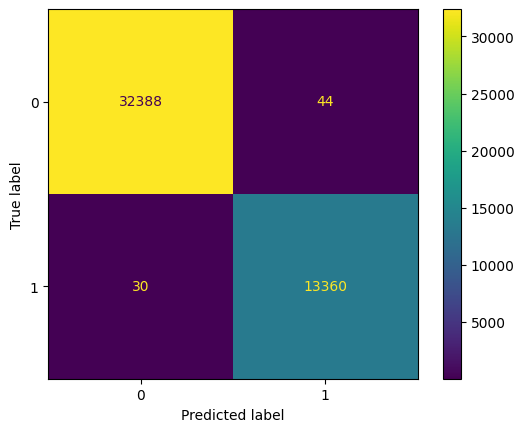

In [ ]:
#CONFUSION MATRIX
cm = confusion_matrix(test_set[:][1], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

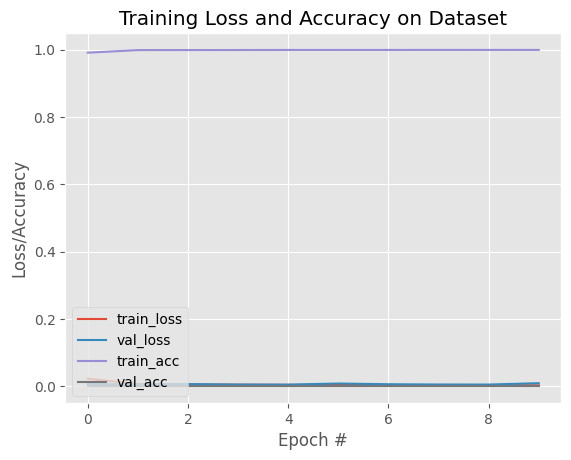

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
# serialize the model to disk
#torch.save(model, args["model"])

In [ ]:
#SAVE THE MODEL

torch.save(model, "/content/drive/MyDrive/ACT Detection System Team/Models/DoS_Normal_Model.pt")
#torch.save(model, "/content/drive/MyDrive/ACT Detection System Team/Models/RPM_Normal_Model.pt")
#torch.save(model, "/content/drive/MyDrive/ACT Detection System Team/Models/Gear_Normal_Model.pt")
#torch.save(model, "/content/drive/MyDrive/ACT Detection System Team/Models/Fuzzy_Normal_Model.pt")

##Loading old models for test

In [ ]:
#DIVIDE INTO TEST,TRAIN, VALIDATION

numTrainSamples = int(len(train_set) * TRAIN_SPLIT)

numValSamples = int(len(train_set) -numTrainSamples)

(trainData, valData) = random_split(train_set, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)

valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

testDataLoader = DataLoader(test_set, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE

valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
#Testing the saving of the models
newModel = torch.load("/content/drive/MyDrive/ACT Detection System Team/Models/DoS_Normal_Model.pt")
#newModel = torch.load("/content/drive/MyDrive/ACT Detection System Team/Models/Fuzzy_Normal_Model.pt")
#newModel = torch.load("/content/drive/MyDrive/ACT Detection System Team/Models/Gear_Normal_Model.pt")
#newModel = torch.load("/content/drive/MyDrive/ACT Detection System Team/Models/RPM_Normal_Model.pt")

In [ ]:
#COULD IMPLEMENT SOME KIND OF RETRAINING

In [ ]:
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	newModel.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = newModel(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
# print(classification_report(test_set.targets.cpu().numpy(),
# 	np.array(preds), target_names=test_set.classes))
print(classification_report(test_set[:][1].numpy(), np.array(preds), target_names=['0','1'], digits = 6))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0   0.690452  0.998939  0.816530     32033
           1   0.979268  0.100677  0.182583     15952

    accuracy                       0.700323     47985
   macro avg   0.834860  0.549808  0.499557     47985
weighted avg   0.786465  0.700323  0.605783     47985



##Adversarial Training, Data Creation

In [32]:
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

###Adversarial Model

In [11]:
class LeNetAdversarial(Module):
	def __init__(self, numChannels, classes):

		# call the parent constructor
		super(LeNetAdversarial, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(4, 4))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(4, 4))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=50, out_features=50)
		self.relu3 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=50, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)


	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		#output = self.logSoftmax(x)
		# return the output predictions
		return x
		#return output

### Training of Initial Model

In [21]:
modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

In [13]:
classifier = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [14]:
classifier.fit(new_x_train, new_y_train, batch_size=64, nb_epochs=5, training_mode=True)

In [33]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(new_x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 91.59329480185096%


In [27]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=new_x_test, y=new_y_test)

In [28]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 22.022172755444984%


####Lets See how Epsilon effects accuracy
https://jaketae.github.io/study/fgsm/


In [ ]:
def testEpsilon(epsilon, x, y, classifier):

  attack = FastGradientMethod(estimator=classifier, eps=epsilon)
  x_test_adv = attack.generate(x,y)
  predictions = classifier.predict(x_test_adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)
  #print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))
  return accuracy


In [ ]:
epsilons = [.05, .1, .15, .2, .25, .3, .4, .5]
accuracies = []
for epsilon in epsilons:
  accuracies.append(testEpsilon(epsilon, new_x_test, new_y_test, classifier))

KeyboardInterrupt: 

In [ ]:
plt.style.use("seaborn")
plt.plot(epsilons, accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

###ADDING ADVERSARIAL DATA TO TRAINING DATA

In [ ]:
x_with_adv = np.vstack((new_x_train, new_x_test, x_test_adv))

y_with_adv = np.vstack((new_y_train, new_y_test, new_y_test))

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(x_with_adv, y_with_adv, test_size=0.25)

In [ ]:
classifier_with_adv = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [ ]:
classifier_with_adv.fit(X_train_adv, y_train_adv, batch_size=64, nb_epochs=10, training_mode=True)

In [ ]:
# Train again now including the adversarial attack
predictions = classifier_with_adv.predict(X_test_adv, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.75420335345096%


In [ ]:
# Generate more adversarial data
attack = FastGradientMethod(estimator=classifier_with_adv, eps=0.2)
x_attack = attack.generate(x=X_test_adv, y=y_test_adv)

In [ ]:
# See if the model can now better handle adversarial data

predictions = classifier_with_adv.predict(x_attack)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 66.59819749125863%


In [ ]:
percent_adversarial = new_x_test.shape[0]/x_with_adv.shape[0]
print("Percent of trained data that is adversarial: {}%".format(percent_adversarial * 100))

Percent of trained data that is adversarial: 16.666618584241853%


####See effect of epsilon on new model

In [ ]:
def testEpsilon(epsilon, x, y, classifier):

  attack = FastGradientMethod(estimator=classifier, eps=epsilon)
  x_attack = attack.generate(x, y)
  predictions = classifier.predict(x_attack)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)
  #print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))
  return accuracy

In [ ]:
epsilons = [.05, .1, .15, .2, .25, .3, .4, .5]
accuracies = []
for epsilon in epsilons:
  accuracies.append(testEpsilon(epsilon, X_test_adv, y_test_adv, classifier_with_adv))

<ipython-input-81-4d6858841792>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


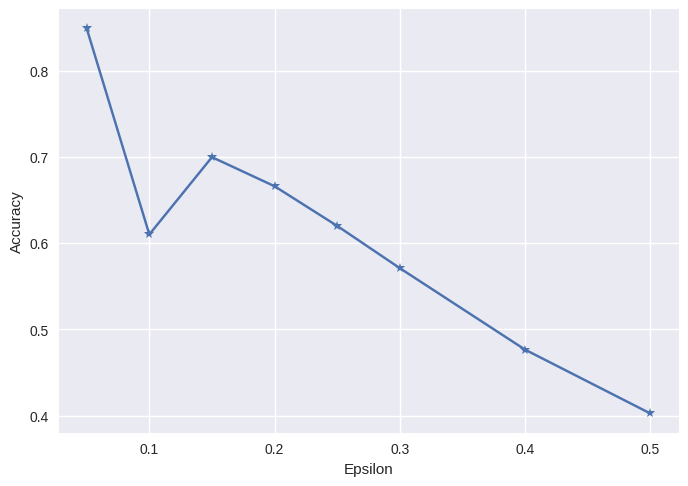

In [ ]:
plt.style.use("seaborn")
plt.plot(epsilons, accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

##Model Trained on 10% adversarial Test on Regular data

In [ ]:
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

In [ ]:
#Sample 10% of of orginal data and apply FGSM
rng = np.random.default_rng()
indices = rng.choice(new_x_train.shape[0], new_x_train.shape[0] // 10)

In [ ]:
#Getting Samples from original Training Data
samples_for_adversarial = new_x_train[indices]

labels_for_adversarial = np.hstack((np.zeros((len(indices), 1), dtype=int), (np.ones((len(indices),1), dtype=int))))

In [ ]:
print(y_test[0])
print(new_y_test[0])
print(labels_for_adversarial[:3])

tensor(0)
[1 0]
[[0 1]
 [0 1]
 [0 1]]


In [ ]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adversarial_data = attack.generate(x=samples_for_adversarial, y=new_y_train[indices])

In [ ]:
#Adding to original data
x_TRAIN = np.vstack((new_x_train, adversarial_data))
y_TRAIN = np.vstack((new_y_train, labels_for_adversarial))


In [ ]:
#TRAIN MODEL AGAIN

modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

In [ ]:
classifier_10_percent = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [ ]:
classifier_10_percent.fit(x_TRAIN, y_TRAIN, batch_size=64, nb_epochs=5, training_mode=True)

In [ ]:
torch.save(classifier_10_percent, '/content/drive/MyDrive/ACT Detection System Team/Models/DoS_10_percent_Adv_Model_Harry.pt')

In [ ]:
predictions = classifier_10_percent.predict(new_x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.93671162323776%


In [ ]:
# # Step 6: Generate adversarial test examples
# attack = FastGradientMethod(estimator=classifier, eps=0.2)
# x_test_adv = attack.generate(x=new_x_test, y=new_y_test)

In [ ]:

# predictions = classifier.predict(x_test_adv)
# accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
# print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 55.1297280400125%


##Model Trained on 30% Adversarial Test on Regular data

In [ ]:
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

In [ ]:
rng = np.random.default_rng()
indices = rng.choice(new_x_train.shape[0], int(new_x_train.shape[0] * .3))

In [ ]:
#Getting Samples
samples_for_adversarial = new_x_train[indices]
#T = 1, R = 0
labels_for_adversarial = np.hstack((np.zeros((len(indices), 1), dtype=int), (np.ones((len(indices),1), dtype=int))))

In [ ]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adversarial_data = attack.generate(x=samples_for_adversarial, y=new_y_train[indices])

In [ ]:
#Adding to original data
x_TRAIN = np.vstack((new_x_train, adversarial_data))
y_TRAIN = np.vstack((new_y_train, labels_for_adversarial))

In [ ]:
#TRAIN MODEL AGAIN

modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

classifier_30_percent = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)


In [ ]:
classifier_30_percent.fit(x_TRAIN, y_TRAIN, batch_size=64, nb_epochs=5, training_mode=True)

In [ ]:
# Step 5: Evaluate the classifier trained on 30% data on regular Data
predictions = classifier_30_percent.predict(new_x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.9279821919602%


In [ ]:
torch.save(classifier_30_percent, '/content/drive/MyDrive/ACT Detection System Team/Models/DoS_30_percent_Adv_Model.pt')

##Model Trained on 50% adversarial Test on Regular data

In [ ]:
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

In [ ]:
#Sample 50% of of orginal data and apply FGSM
rng = np.random.default_rng()
indices = rng.choice(new_x_train.shape[0], new_x_train.shape[0] // 2)

In [ ]:
#Getting Samples
samples_for_adversarial = new_x_train[indices]
#T = 1, R = 0
labels_for_adversarial = np.hstack((np.zeros((len(indices), 1), dtype=int), (np.ones((len(indices),1), dtype=int))))

In [ ]:
print(y_test[0])
print(new_y_test[0])
print((labels_for_adversarial[:3]))

tensor(0)
[1 0]
[[0 1]
 [0 1]
 [0 1]]


In [ ]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adversarial_data = attack.generate(x=samples_for_adversarial, y=new_y_train[indices])

In [ ]:
#Adding to original data
x_TRAIN = np.vstack((new_x_train, adversarial_data))
y_TRAIN = np.vstack((new_y_train, labels_for_adversarial))

In [ ]:
#TRAIN MODEL AGAIN

modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

In [ ]:
classifier_50_percent = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [ ]:
classifier_50_percent.fit(x_TRAIN, y_TRAIN, batch_size=64, nb_epochs=5, training_mode=True)

In [ ]:
# Step 5: Evaluate the classifier trained on 50% data on regular Data
predictions = classifier_50_percent.predict(new_x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.93016454977958%


In [ ]:
torch.save(classifier_50_percent, '/content/drive/MyDrive/ACT Detection System Team/Models/DoS_50_percent_Adv_Model.pt')

In [ ]:
#TEST PERFORMANCE ON Y_TEST
def testEpsilon(epsilon, x, y, classifier):

  attack = FastGradientMethod(estimator=classifier, eps=epsilon)
  x_test_adv = attack.generate(x,y)
  predictions = classifier.predict(x_test_adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)
  return accuracy


NameError: name 'Y_TEST' is not defined

##Model Trained on 80% adversarial

In [ ]:
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

In [ ]:
rng = np.random.default_rng()
indices = rng.choice(new_x_train.shape[0], int(new_x_train.shape[0] * .8))

In [ ]:
#Getting Samples
samples_for_adversarial = new_x_train[indices]
#T = 1, R = 0
labels_for_adversarial = np.hstack((np.zeros((len(indices), 1), dtype=int), (np.ones((len(indices),1), dtype=int))))

In [ ]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adversarial_data = attack.generate(x=samples_for_adversarial, y=new_y_train[indices])

In [ ]:
#Adding to original data
x_TRAIN = np.vstack((new_x_train, adversarial_data))
y_TRAIN = np.vstack((new_y_train, labels_for_adversarial))

In [ ]:
#TRAIN MODEL AGAIN

modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

classifier_80_percent = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [ ]:
classifier_80_percent.fit(x_TRAIN, y_TRAIN, batch_size=64, nb_epochs=5, training_mode=True)

In [ ]:
# Step 5: Evaluate the classifier trained on 30% data on regular Data
predictions = classifier_80_percent.predict(new_x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("80% adversarial data accuracy on DoS: {}%".format(accuracy * 100))

80% adversarial data accuracy on DoS: 99.84941731046221%


In [ ]:
torch.save(classifier_80_percent, '/content/drive/MyDrive/ACT Detection System Team/Models/DoS_80_percent_Adv_Model.pt')

##Model Trained on 100% adversarial

In [ ]:
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

In [ ]:
#Sample 100% of of orginal data and apply FGSM
rng = np.random.default_rng()
indices = rng.choice(new_x_train.shape[0], new_x_train.shape[0])

In [ ]:
#Getting Samples
samples_for_adversarial = new_x_train[indices]
#T = 1, R = 0
labels_for_adversarial = np.hstack((np.zeros((len(indices), 1), dtype=int), (np.ones((len(indices),1), dtype=int))))

In [ ]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adversarial_data = attack.generate(x=samples_for_adversarial, y=new_y_train[indices])

In [ ]:
#Adding to original data
x_TRAIN = np.vstack((new_x_train, adversarial_data))
y_TRAIN = np.vstack((new_y_train, labels_for_adversarial))

In [ ]:
#TRAIN MODEL AGAIN

modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

In [ ]:
classifier_100_percent = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [ ]:
classifier_100_percent.fit(x_TRAIN, y_TRAIN, batch_size=64, nb_epochs=5, training_mode=True)

In [ ]:
torch.save(classifier_100_percent, '/content/drive/MyDrive/ACT Detection System Team/Models/DoS_100_percent_Adv_Model.pt')

In [ ]:
# Step 5: Evaluate the classifier trained on 100% data on regular Data
predictions = classifier_100_percent.predict(new_x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(new_y_test, axis=1)) / len(new_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.87778796211427%


##Testing the DoS models on Other Datasets

In [ ]:
fuzzyData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/Fuzzy_Tensor_Dataset.pt')

In [ ]:
fuzzyX = fuzzyData[:][0]
fuzzyY = fuzzyData[:][1]

In [ ]:
fuzzyY = F.one_hot(fuzzyY, num_classes = 2)

fuzzyX = np.array(fuzzyX)
fuzzyY = np.array(fuzzyY)

In [ ]:
predictions = classifier.predict(fuzzyX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(fuzzyY, axis=1)) / len(fuzzyY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 67.13389016705011%


In [ ]:
RPMData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/RPM_Tensor_Dataset.pt')
GEARData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/Gear_Tensor_Dataset.pt')

In [ ]:
RPMX = RPMData[:][0]
RPMY = RPMData[:][1]

RPMY = F.one_hot(RPMY, num_classes = 2)

RPMX = np.array(RPMX)
RPMY = np.array(RPMY)

In [ ]:
predictions = classifier.predict(RPMX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(RPMY, axis=1)) / len(RPMY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 55.31718226382696%


In [ ]:
GEARX = GEARData[:][0]
GEARY = GEARData[:][1]

GEARY = F.one_hot(GEARY, num_classes = 2)

GEARX = np.array(GEARX)
GEARY = np.array(GEARY)

In [ ]:
predictions = classifier.predict(GEARX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(GEARY, axis=1)) / len(GEARY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 60.582795575017286%


####Testing 10% on other datasets

In [ ]:
classifier_10_percent_DoS = torch.load('/content/drive/MyDrive/ACT Detection System Team/Models/DoS_10_percent_Adv_Model_Harry.pt')

In [ ]:
predictions = classifier_10_percent_DoS.predict(fuzzyX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(fuzzyY, axis=1)) / len(fuzzyY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 68.70019339135074%


In [ ]:
predictions = classifier_10_percent_DoS.predict(RPMX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(RPMY, axis=1)) / len(RPMY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 55.48716315395906%


In [ ]:
predictions = classifier_10_percent_DoS.predict(GEARX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(GEARY, axis=1)) / len(GEARY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 59.85862237842821%


####Testing 30% Model on Data

In [ ]:
classifier_30_percent_DoS = torch.load('/content/drive/MyDrive/ACT Detection System Team/Models/DoS_30_percent_Adv_Model.pt')

In [ ]:
predictions = classifier_30_percent_DoS.predict(fuzzyX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(fuzzyY, axis=1)) / len(fuzzyY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 68.26798039411824%


In [ ]:
predictions = classifier_30_percent_DoS.predict(RPMX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(RPMY, axis=1)) / len(RPMY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 55.89913313207965%


In [ ]:
predictions = classifier_30_percent_DoS.predict(GEARX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(GEARY, axis=1)) / len(GEARY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 60.05812111085503%


####Testing 50% On Data

In [ ]:
classifier_50_percent_DoS = torch.load('/content/drive/MyDrive/ACT Detection System Team/Models/DoS_50_percent_Adv_Model.pt')

In [ ]:
predictions = classifier_50_percent_DoS.predict(fuzzyX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(fuzzyY, axis=1)) / len(fuzzyY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

In [ ]:
predictions = classifier_50_percent_DoS.predict(RPMX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(RPMY, axis=1)) / len(RPMY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

In [ ]:
predictions = classifier_50_percent_DoS.predict(GEARX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(GEARY, axis=1)) / len(GEARY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

####Testing 80% Model on Data


In [ ]:
classifier_80_percent_DoS = torch.load('/content/drive/MyDrive/ACT Detection System Team/Models/DoS_80_percent_Adv_Model.pt')

In [ ]:
predictions = classifier_80_percent_DoS.predict(fuzzyX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(fuzzyY, axis=1)) / len(fuzzyY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 66.73210296422259%


In [ ]:
predictions = classifier_80_percent_DoS.predict(RPMX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(RPMY, axis=1)) / len(RPMY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 55.33102999418396%


In [ ]:
predictions = classifier_80_percent_DoS.predict(GEARX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(GEARY, axis=1)) / len(GEARY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 57.687903318737035%


#### Testing 100% Model on Data

In [ ]:
classifier_100_percent_DoS = torch.load('/content/drive/MyDrive/ACT Detection System Team/Models/DoS_100_percent_Adv_Model.pt')

In [ ]:
predictions = classifier_100_percent_DoS.predict(fuzzyX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(fuzzyY, axis=1)) / len(fuzzyY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 66.9075722716815%


In [ ]:
predictions = classifier_100_percent_DoS.predict(RPMX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(RPMY, axis=1)) / len(RPMY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 55.370149832442465%


In [ ]:
predictions = classifier_100_percent_DoS.predict(GEARX, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(GEARY, axis=1)) / len(GEARY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 58.10958746254897%


#MODEL TRAINED ON 20% Adversarial and 10% of Fuzzy EPS = .2


In [ ]:
DoSData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/DoS_Tensor_Dataset.pt')

In [ ]:
trainSize = math.ceil(len(frameData) * .8)
testSize = len(frameData) - trainSize

train_set, test_set = torch.utils.data.random_split(frameData, [trainSize, testSize])

In [ ]:
#Generate 20% Adversarial Data
x_train = train_set[:][0]
y_train = train_set[:][1]
x_test = test_set[:][0]
y_test = test_set[:][1]

new_y_train = F.one_hot(y_train, num_classes = 2)
new_y_test = F.one_hot(y_test, num_classes = 2)

new_x_train = np.array(x_train)
new_x_test = np.array(x_test)
new_y_test = np.array(new_y_test)
new_y_train = np.array(new_y_train)

rng = np.random.default_rng()
indices = rng.choice(new_x_train.shape[0], int(new_x_train.shape[0] * .3))

#Getting Samples
samples_for_adversarial = new_x_train[indices]
#T = 1, R = 0
labels_for_adversarial = np.hstack((np.zeros((len(indices), 1), dtype=int), (np.ones((len(indices),1), dtype=int))))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adversarial_data = attack.generate(x=samples_for_adversarial, y=new_y_train[indices])

In [ ]:
fuzzyData = torch.load('/content/drive/MyDrive/ACT Detection System Team/datasets/Fuzzy_Tensor_Dataset.pt')

In [ ]:
#Take additional 10% fuzzy Data

#size of DoS set

#take 10% of size from

fuzzyTrainSize = math.ceil(len(train_set) * .1)
fuzzyTestSize = len(fuzzyData) - fuzzyTrainSize
fuzzy_train_set, fuzzy_test_set = torch.utils.data.random_split(fuzzyData, [fuzzyTrainSize, fuzzyTestSize])

x_fuzzy_train = fuzzy_train_set[:][0]
y_fuzzy_train = fuzzy_train_set[:][1]

x_fuzzy_test = fuzzy_test_set[:][0]
y_fuzzy_test = fuzzy_test_set[:][1]

y_fuzzy_train = F.one_hot(y_fuzzy_train, num_classes = 2)
y_fuzzy_test = F.one_hot(y_fuzzy_test, num_classes = 2)

x_fuzzy_train = np.array(x_fuzzy_train)
x_fuzzy_test = np.array(x_fuzzy_test)
y_fuzzy_test = np.array(y_fuzzy_test)
y_fuzzy_train = np.array(y_fuzzy_train)

In [ ]:
#Adding to original data
x_TRAIN = np.vstack((new_x_train, adversarial_data, x_fuzzy_train))
y_TRAIN = np.vstack((new_y_train, labels_for_adversarial, y_fuzzy_train))

In [ ]:
#TRAIN MODEL AGAIN

modelAdv = LeNetAdversarial(numChannels = 1, classes= 2)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(modelAdv.parameters(), lr=0.01)

classifier_20Adv_10fuzzy = PyTorchClassifier(
    model=modelAdv,
    clip_values = (0,1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 16, 16),
    nb_classes=2,
)

In [ ]:
#Train
classifier_20Adv_10fuzzy.fit(x_TRAIN, y_TRAIN, batch_size=64, nb_epochs=5, training_mode=True)

In [ ]:
#save it
#Test Model on Fuzzy data
torch.save(classifier_20Adv_10fuzzy, '/content/drive/MyDrive/ACT Detection System Team/Models/DoS_20Adv_10fuzzy_Model.pt')

In [ ]:
#Test MNodel on Fuzzy data
# Step 5: Evaluate the classifier trained on 30% data on regular Data
predictions = classifier_20Adv_10fuzzy.predict(x_fuzzy_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_fuzzy_test, axis=1)) / len(y_fuzzy_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

###Test on DoS

### Test on Remaining Fuzzy
